In [1]:
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
import os 
import fnmatch
sys.path.insert(1, r'C:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\utils')
sys.path.insert(1, r'C:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\tracking')
sys.path.insert(1, r'C:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\muon_decay')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display
from find_muon_track import find_muon_track
from find_muon_decay import find_muon_decay
# from find_muon_decay_Kim import find_muon_decay_kim



C:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\tracking\hit.py:12: SyntaxWarning: invalid escape sequence '\E'
  sys.path.insert(1, 'C:\\Users\\eliot\\OneDrive\\Documents\EPFL\\TP4_ECAL\\Code\\ecal_reco\\utils')


selected 75.80% of all events


In [2]:
# Define the paths needed
raw_data_directory = "C:\\Users\\eliot\\EPFL\\TP4_ECAL\\raw_data\\" #path to the ecal data
current_directory = os.getcwd()
data_storage = current_directory+"\\extracted_data\\"
runs = ["run_000007"]  # List of the runs to analyse. If empty, the program will go through all the data available in the raw_data directory
suffix = "" # If one wants to re-run on already analysed data without overwriting the extracted data
separator = "\\" # "/" if linux or mac

In [3]:
# Analyse data
if len(runs) == 0:
    runs = fnmatch.filter(os.listdir(raw_data_directory), '*')


for run in runs:
    print(raw_data_directory+run)
    df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\")

    _, _ = find_muon_track(df_hits,df_hits_total, save_indices = True, save_time_intervals=False, save_hits = False, save_stats = False, \
                    run_name = "_"+run, storage_dir = data_storage, return_stats = False)




C:\Users\eliot\EPFL\TP4_ECAL\raw_data\run_000007
C:\Users\eliot\EPFL\TP4_ECAL\raw_data\run_000007\data_0000.root
selected 74.62% of all events


100%|██████████| 48267/48267 [02:07<00:00, 377.86it/s]


In [11]:
# Load of the data frame to visualize the decays
run = "run_000007"

# Load the data
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\")


C:\Users\eliot\EPFL\TP4_ECAL\raw_data\run_000010\data_0000.root
selected 74.89% of all events


In [12]:

good_candidates = np.loadtxt(data_storage+"events_indices_"+run+".txt")

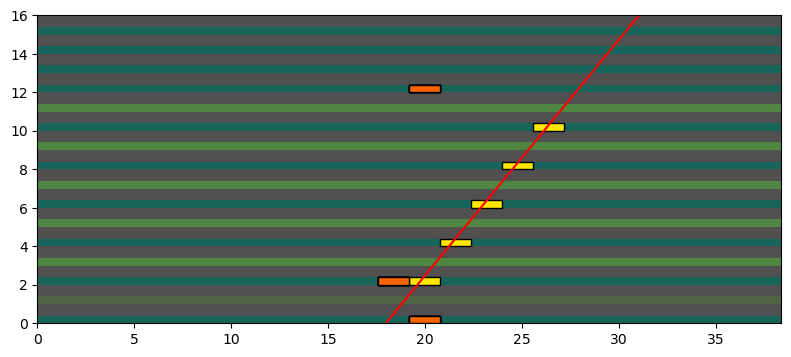

In [13]:
#This cell allows to plot the final candidates for muon track 
#press enter to plot the next candidate, press and caracter + enter to stop the loop
%matplotlib inline

i = 0

kb = ""
while kb == "":
    event = df_hits.loc[good_candidates[i]]
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits' ])]


    hitsX = [h for h in hits if h.is_sidex]
    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    hitsX_next_event = [h for h in hits_next_event if h.is_sidex]

    track = Track(hitsX)



    fig,ax = plot_hits(hits,True,True,scaling = 0.5,hits_next = hits_next_event)
    z = np.linspace(0,16)
    x = track.t*z+track.x0
    ax.plot(x,z,'r-')
    display.clear_output(wait=False)
    print("i = ", i)
    print(hits_next_event[0].timestamp_event-hits_next_event[0].timestamp-hits[-1].timestamp_event+hits[-1].timestamp)
    fig.savefig("fig_muon_decay_problem.pdf".format(i))
    display.display(fig)
    kb = input()
    i = i+1



display.clear_output(wait=False)

In [14]:
filtering = pd.read_pickle(data_storage+"filtering_data_"+run)
og_len = filtering['og_len'][0]
new_len = filtering['new_len'][0]
low_number = filtering['low_number'][0]
bottom_touch = filtering['bottom_touch'][0]
side_touch = filtering['side_touch'][0]
bad_fit = filtering['bad_fit'][0]
too_large_time_interval = filtering['too_large_time_interval'][0]
hits_far_from_track = filtering['hits_far_from_track'][0]
no_spacial_correlation = filtering['no_spacial_correlation'][0]

In [16]:
# Stats on the whole set of analysed data
og_len = 0
new_len = 0
low_number = 0
bottom_touch = 0
side_touch = 0
bad_fit = 0
too_large_time_interval = 0
hits_far_from_track = 0
no_spacial_correlation = 0

n_good_candidates = 0

runs = fnmatch.filter(os.listdir(raw_data_directory), '*')
for run in runs:
    time_intervals = np.loadtxt(data_storage+"events_indices_"+run+".txt")
    n_good_candidates += len(time_intervals)

    filtering = pd.read_pickle(data_storage+"filtering_data"+"_"+run)
    og_len += filtering['og_len'][0]
    new_len += filtering['new_len'][0]
    low_number += filtering['low_number'][0]
    bottom_touch += filtering['bottom_touch'][0]
    side_touch += filtering['side_touch'][0]
    bad_fit += filtering['bad_fit'][0]
    too_large_time_interval += filtering['too_large_time_interval'][0]
    hits_far_from_track += filtering['hits_far_from_track'][0]
    no_spacial_correlation += filtering['no_spacial_correlation'][0]

FileNotFoundError: c:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\time_alignement\extracted_data\events_indices_run_000004.txt not found.

In [ ]:
# Showcase of the numbers of rejection at each step of the filtering 
print("original length : ", og_len)
print("n_hits between 6 and 50 : ", new_len)
n = new_len
print("\u2937 Too low number of hits in one plane : ", low_number, " over ", n)
n -= low_number
print(" \u2937 Last layer touched : \t\t", bottom_touch, " over ", n)
n -= bottom_touch
print("  \u2937 Possible side exit : \t\t", side_touch, " over ", n)
n -= side_touch
print("   \u2937 Bad fit : \t\t\t\t", bad_fit, " over ", n)
n -= bad_fit
print("    \u2937 Too large time interval : \t", too_large_time_interval, " over ", n)
n -= too_large_time_interval
print("     \u2937 Hits far from track : \t\t", hits_far_from_track, " over ", n)
n -= hits_far_from_track
print("      \u2937 No spacial correlation : \t", no_spacial_correlation, " over ", n)
print("Final number : ", n_good_candidates)

In [ ]:
run = "run_000010"

# Load the data
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\")

In [ ]:
time_intervals = np.loadtxt(data_storage+"time_intervals_"+run+".txt")
indices = np.loadtxt(data_storage+"events_indices_"+run+".txt").astype(int)
# large_time = []
# for i,t in enumerate(time_intervals):
#     if t>1400:
#         large_time.append(i)

# large_time_indices = indices[large_time]

%matplotlib inline

i = 1

kb = ""
while kb == "":
    # event = df_hits.loc[large_time_indices[i]]
    # next_event = df_hits_total.loc[large_time_indices[i]+1]
    event = df_hits.loc[indices[i]]
    next_event = df_hits_total.loc[indices[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits'
    
    ])]
    hitsX = [h for h in hits if h.is_sidex]
    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    hitsX_next_event = [h for h in hits_next_event if h.is_sidex]

    track = Track(hitsX)
    fig,ax = plot_hits(hits,True,True,scaling = 0.5,hits_next = hits_next_event)
    z = np.linspace(0,16)
    x = track.t*z+track.x0
    ax.plot(x,z,'r-')
    display.clear_output(wait=False)
    print("i = ", i)
    print(hits_next_event[0].timestamp_event-hits_next_event[0].timestamp-hits[-1].timestamp_event+hits[-1].timestamp)
    fig.savefig("fig_muon_decay_problem.pdf".format(i))
    display.display(fig)
    kb = input()
    i = i+1
display.clear_output(wait=False)



In [ ]:
fig.savefig("shower_section.pdf")